In [22]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine, text
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Assuming the notebook is in 'notebooks/' and the project root is one level up
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify the path has been added (optional)
print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: d:\Projects\EDA-Clustering-Time-series---Regression-Model-Airbnb-Data


In [3]:
from database import get_sqlalchemy_engine
engine = get_sqlalchemy_engine()

✅ Successfully connected to SQL Server via pyodbc.
✅ SQLAlchemy engine created successfully.


In [4]:
# Load full table
query = "SELECT * FROM listing_features"
df = pd.read_sql(query, engine)

print(f"✅ Loaded {len(df)} rows.")
print(df.info())
print(df.describe(include='all'))

✅ Loaded 1178740 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178740 entries, 0 to 1178739
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   listing_id              1178740 non-null  int64  
 1   total_weeks             1178740 non-null  int64  
 2   offline_weeks           1178740 non-null  int64  
 3   pct_offline_weeks       1178740 non-null  float64
 4   mean_availability       1178740 non-null  float64
 5   first_week              1178740 non-null  object 
 6   last_week               1178740 non-null  object 
 7   base_price              996981 non-null   float64
 8   number_of_reviews       1178740 non-null  int64  
 9   property_city           1178740 non-null  object 
 10  property_country        1178740 non-null  object 
 11  property_neighbourhood  1178740 non-null  object 
 12  latitude                1178740 non-null  float64
 13  longitude               1178740 no

In [5]:
# Filter dataset
df_filtered = df[
    (df['base_price'].notna()) &          # base_price is not null
    (df['base_price'] > 0) &             # base_price > 0
    (df['pct_offline_weeks'] < 1)        # not offline 100% of the year
].copy()

print(f"✅ Loaded {len(df_filtered)} rows.")
print(df_filtered.info())
print(df_filtered.describe(include='all'))

✅ Loaded 986250 rows.
<class 'pandas.core.frame.DataFrame'>
Index: 986250 entries, 0 to 1178738
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   listing_id              986250 non-null  int64  
 1   total_weeks             986250 non-null  int64  
 2   offline_weeks           986250 non-null  int64  
 3   pct_offline_weeks       986250 non-null  float64
 4   mean_availability       986250 non-null  float64
 5   first_week              986250 non-null  object 
 6   last_week               986250 non-null  object 
 7   base_price              986250 non-null  float64
 8   number_of_reviews       986250 non-null  int64  
 9   property_city           986250 non-null  object 
 10  property_country        986250 non-null  object 
 11  property_neighbourhood  986250 non-null  object 
 12  latitude                986250 non-null  float64
 13  longitude               986250 non-null  float64
 14  ho

In [6]:
features = [
    'base_price',          # Price level
    'mean_availability',   # Weekly availability
    'pct_offline_weeks',   # Host activeness
    'number_of_reviews',   # Popularity
    'review_scores_rating',# Quality perception
    'latitude', 'longitude' # Location
]


In [7]:
# Check NaN count and percentage for the selected features
nan_summary = df_filtered[features].isna().sum().to_frame('NaN_count')
nan_summary['NaN_%'] = 100 * nan_summary['NaN_count'] / len(df_filtered)

print("🧹 Missing values in selected features:")
display(nan_summary)


🧹 Missing values in selected features:


,NaN_count,NaN_%
base_price,0,0.000000
mean_availability,0,0.000000
pct_offline_weeks,0,0.000000
number_of_reviews,0,0.000000
review_scores_rating,185366,18.795032
latitude,0,0.000000
longitude,0,0.000000


In [8]:
rows_before = len(df_filtered)
rows_after = df_filtered[features].dropna().shape[0]
loss_pct = 100 * (rows_before - rows_after) / rows_before

print(f"📊 Rows before: {rows_before:,}")
print(f"📉 Rows after dropna(): {rows_after:,}")
print(f"⚠️ Data loss: {loss_pct:.2f}%")


📊 Rows before: 986,250
📉 Rows after dropna(): 800,884
⚠️ Data loss: 18.80%


In [9]:
df_filtered['review_scores_rating'] = df_filtered.groupby('property_city')['review_scores_rating']\
    .transform(lambda x: x.fillna(x.median()))


In [10]:
# Check NaN count and percentage for the selected features
nan_summary = df_filtered[features].isna().sum().to_frame('NaN_count')
nan_summary['NaN_%'] = 100 * nan_summary['NaN_count'] / len(df_filtered)

print("🧹 Missing values in selected features:")
display(nan_summary)


🧹 Missing values in selected features:


,NaN_count,NaN_%
base_price,0,0.0
mean_availability,0,0.0
pct_offline_weeks,0,0.0
number_of_reviews,0,0.0
review_scores_rating,0,0.0
latitude,0,0.0
longitude,0,0.0


In [11]:
# Select and drop NaN rows (safeguard)
X = df_filtered[features].dropna().copy()

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Feature matrix shape: {X_scaled.shape}")

✅ Feature matrix shape: (986250, 7)


In [12]:
# --- STEP 1: Cap outliers in base_price ---
def cap_outliers(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    df[column] = np.clip(df[column], lower, upper)
    return df

df_filtered = cap_outliers(df_filtered, 'base_price')

In [13]:
# --- STEP 2: Feature engineering ---
df_filtered['log_price'] = np.log1p(df_filtered['base_price'])
df_filtered['log_reviews'] = np.log1p(df_filtered['number_of_reviews'])


In [14]:
features = [
    'log_price', 'mean_availability', 'pct_offline_weeks',
    'log_reviews', 'review_scores_rating', 'latitude', 'longitude'
]

In [15]:
X = df_filtered[features].dropna().copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Feature matrix shape after capping/log transform: {X_scaled.shape}")


✅ Feature matrix shape after capping/log transform: (986250, 7)


Explained variance ratio: [0.2874979  0.21198772]


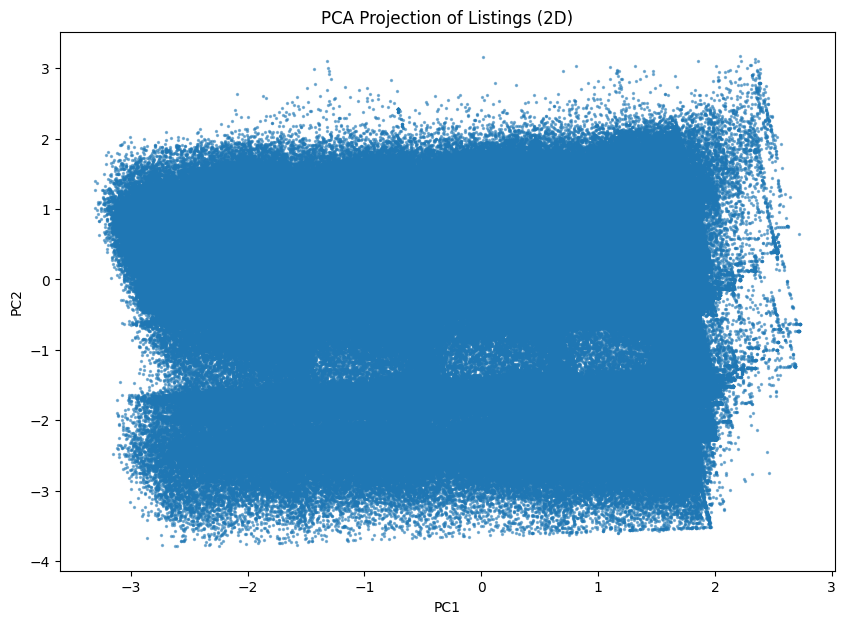

In [16]:
# --- STEP 3: PCA (Dimensionality Reduction) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# --- Visualize 2D PCA projection ---
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2, alpha=0.5)
plt.title("PCA Projection of Listings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [17]:
# Features for geo-based clustering
geo_features = ['latitude', 'longitude', 'base_price', 'review_scores_rating']

X_geo = df_filtered[geo_features].dropna().copy()

# Scale all features for distance-based algorithms
scaler = StandardScaler()
X_geo_scaled = scaler.fit_transform(X_geo)

print(f"✅ Geo feature matrix shape: {X_geo_scaled.shape}")

✅ Geo feature matrix shape: (986250, 4)


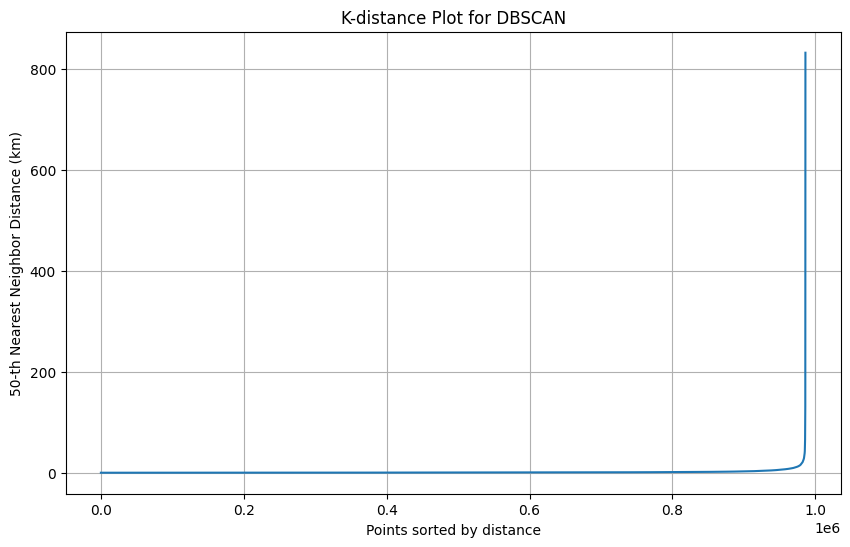

In [20]:
# Convert coordinates to radians for Haversine distance
coords = np.radians(df_filtered[['latitude', 'longitude']])

# Choose k = min_samples (same as what you plan to use in DBSCAN)
k = 50
nbrs = NearestNeighbors(n_neighbors=k, metric='haversine').fit(coords)
distances, _ = nbrs.kneighbors(coords)

# Take the distance to the k-th neighbor for each point
k_distances = np.sort(distances[:, k-1])  # distances are in radians

# Convert radians to km: distance (km) = radians * Earth radius (6371 km)
k_distances_km = k_distances * 6371

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances_km)
plt.ylabel(f"{k}-th Nearest Neighbor Distance (km)")
plt.xlabel("Points sorted by distance")
plt.title("K-distance Plot for DBSCAN")
plt.grid(True)
plt.show()

In [23]:
# Use KneeLocator to find the "elbow" point
kneedle = KneeLocator(
    range(len(k_distances_km)), 
    k_distances_km, 
    S=1.0,       # Sensitivity parameter, tweak if needed
    curve="convex", 
    direction="increasing"
)

eps_estimate = k_distances_km[kneedle.knee] if kneedle.knee else k_distances_km[int(len(k_distances_km)*0.95)]
print(f"💡 Suggested eps for DBSCAN: {eps_estimate:.2f} km")

💡 Suggested eps for DBSCAN: 364.10 km


In [24]:
# Convert degrees to radians for Haversine metric
coords = np.radians(df_filtered[['latitude', 'longitude']])

# eps ≈ distance threshold in radians → 10 km ≈ 10 / 6371 ≈ 0.00157
db = DBSCAN(eps=eps_estimate/6371, min_samples=50, metric='haversine').fit(coords)
df_filtered['geo_cluster'] = db.labels_

print(df_filtered['geo_cluster'].value_counts().head(10))
print(f"🧭 Total clusters found: {len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)}")
plt.figure(figsize=(10, 8))
plt.scatter(
    df_filtered['longitude'], df_filtered['latitude'],
    c=df_filtered['geo_cluster'], cmap='tab20', s=3
)
plt.title("DBSCAN Geographic Clusters (Haversine distance)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

MemoryError: 

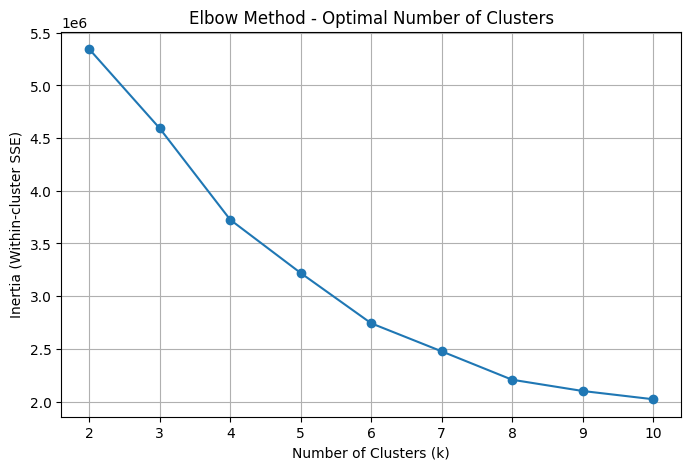

In [ ]:
# inertias = []
# K_range = range(2, 11)  # Test cluster counts from 2 to 10

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
#     kmeans.fit(X_scaled)
#     inertias.append(kmeans.inertia_)

# plt.figure(figsize=(8, 5))
# plt.plot(K_range, inertias, marker='o')
# plt.title("Elbow Method - Optimal Number of Clusters")
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Inertia (Within-cluster SSE)")
# plt.grid(True)
# plt.show()

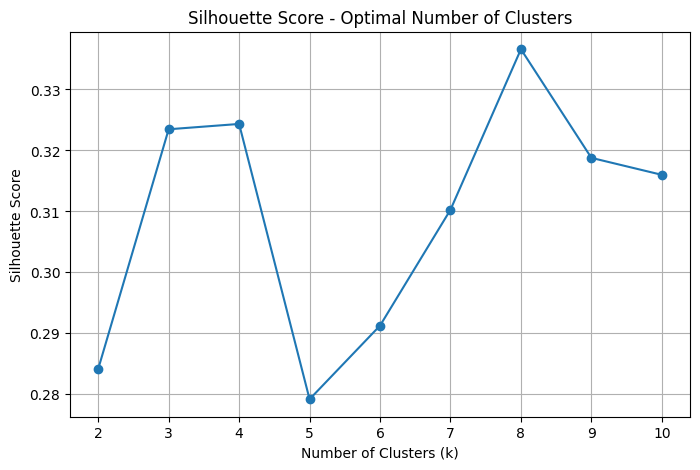

In [ ]:
# sample_size = 100_000
# if X_scaled.shape[0] > sample_size:
#     np.random.seed(42)
#     idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
#     X_sample = X_scaled[idx]
# else:
#     X_sample = X_scaled

# sil_scores = []
# K_range = range(2, 11)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
#     labels = kmeans.fit_predict(X_sample)
#     score = silhouette_score(X_sample, labels)
#     sil_scores.append(score)

# plt.figure(figsize=(8,5))
# plt.plot(K_range, sil_scores, marker='o')
# plt.title("Silhouette Score - Optimal Number of Clusters")
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Silhouette Score")
# plt.grid(True)
# plt.show()